<a href="https://colab.research.google.com/github/OhOmah/F1Revisited/blob/main/Pitstop_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PURPOSE OF THIS NOTEBOOK

This notebook serves as the initial analysis to see which visualizations would work best for the pitstop dashboard. I want the dashboard to:
1. Allow a user to pick a driver/race
2. Generate a dashboard showcasing their pace over a race stint compared to other drivers/teammate
3. Share pitstop time, compare to average pitstop time at that track
4. Show potential finishing place if pitstop was within the average time vs. if it was the fastest time
5.

In [7]:
# Install the needed libaries
!pip install dash
!pip install plotly
!pip install plotly.express

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [8]:
# Import the libaries I need
import pandas as pd
import numpy as np
import dash
import statsmodels.api as sm

# Test if it's running in a colab notebook or locally
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [9]:
# Import the data I need
if IN_COLAB == True:
  print("in colab")
  # Pitstop times
  pitstop = pd.read_csv('/content/drive/MyDrive/F1 Dataset/archive.zip (Unzipped Files)/pit_stops.csv')
  # Lap times
  laptimes = pd.read_csv('/content/drive/MyDrive/F1 Dataset/archive.zip (Unzipped Files)/lap_times.csv')
  # Finishing results
  results = pd.read_csv('/content/drive/MyDrive/F1 Dataset/archive.zip (Unzipped Files)/results.csv')
  # Driver information
  drivers = pd.read_csv('/content/drive/MyDrive/F1 Dataset/archive.zip (Unzipped Files)/drivers.csv')
  # Race information
  race = pd.read_csv('/content/drive/MyDrive/F1 Dataset/archive.zip (Unzipped Files)/races.csv')
  # Status
  status = pd.read_csv('/content/drive/MyDrive/F1 Dataset/archive.zip (Unzipped Files)/status.csv')
  print('Files imported successfully')

else:
  print("not in colab")
  # Pitstop times
  pitstop = pd.read_csv('Data/archive(2)/pit_stops.csv')
  # Lap times
  laptimes = pd.read_csv('Data/archive(2)/lap_times.csv')
  # Finishing results
  results = pd.read_csv('Data/archive(2)/results.csv')
  # Driver information
  drivers = pd.read_csv('Data/archive(2)/drivers.csv')
  # Race information
  race = pd.read_csv('Data/archive(2)/races.csv')
  # Status
  status = pd.read_csv('Data/archive(2)/status.csv')
  print("Files imported successfully")


not in colab


Files imported successfully


## Log what data I need so I can get it ready for the dashboard.



In [10]:
pitstop.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [11]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [12]:
# Calculate the average pitstop time for a driver:
avg_pitstop_time = pitstop.groupby(['driverId', 'raceId']).agg({'milliseconds': 'mean'}).reset_index(drop=False).rename(columns={'milliseconds': "avgPitStopTimeMs"})

In [13]:
avg_pitstop_time.head()

,driverId,raceId,avgPitStopTimeMs
0,1,841,23213.000000
1,1,842,23252.750000
2,1,843,20659.333333
3,1,844,24909.250000
4,1,845,20364.250000


In [14]:
# Merge in the average pitstop times to the pitstop table
#print(avg_pitstop_time.shape)
#print(pitstop.shape)
#pitstop = pitstop.merge(avg_pitstop_time)
#print(pitstop.shape)

# Add drivers to pitstops, we only want to get their forename and surname
print(pitstop.shape)
pitstop = pitstop.merge(drivers[['driverId', 'forename', 'surname']])
print(pitstop.shape)
pitstop.head()

(10990, 7)
(10990, 9)


,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari
3,842,153,1,16,16:32:25,23.584,23584,Jaime,Alguersuari
4,842,153,2,32,17:00:55,22.888,22888,Jaime,Alguersuari


In [15]:
print("Size of the average pitstops: ", avg_pitstop_time.shape)
print("Size of the pitstop table: ", pitstop.shape)
pitstop = pitstop.merge(avg_pitstop_time)
print(pitstop.shape)

Size of the average pitstops:  (5346, 3)
Size of the pitstop table:  (10990, 9)
(10990, 10)


In [16]:
# Add some general race information
print(pitstop.shape)
pitstop = pitstop.merge(race[['raceId', 'year', 'name']])
print(pitstop.shape)
pitstop.head()

(10990, 10)
(10990, 12)


,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix


In [17]:
# Rename milliseconds to totalRaceTimeMilliseconds
results = results.rename(columns={'milliseconds': 'totalRaceTimeMilliseconds'})

# Add in some results information
print(pitstop.shape)
pitstop = pitstop.merge(results[['raceId','driverId', 'laps', 'statusId', 'totalRaceTimeMilliseconds', 'positionOrder']])
print(pitstop.shape)
pitstop.head()

(10990, 12)
(10990, 16)


,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19


In [18]:
# Take a look at the results table to see what information we need
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,totalRaceTimeMilliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [19]:
# Add in the results columns I would want to add
print(pitstop.shape)
pitstop = pitstop.merge(results[['raceId', 'driverId', 'grid', 'position', 'fastestLapTime']])
print(pitstop.shape)
pitstop.head()

(10990, 16)
(10990, 19)


,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319


In [20]:
# merge in the status descriptions
print(pitstop.shape)


(10990, 19)


In [21]:
# Function to get milliseconds from timing for math operations
def convert_to_milliseconds(time):
  hours, minutes, seconds = (["0", "0"] + time.split(":"))[-3:]
  hours = int(hours)
  minutes = int(minutes)
  seconds = float(seconds)
  milliseconds = (hours * 60 * 60 + minutes * 60 + seconds) * 1000
  return milliseconds


In [22]:
# reaname columns to match actual laptimes
laptimes = laptimes.rename(columns={"milliseconds":"lapTimeMilliseconds", "lap":"raceLapNumber"})

In [23]:
# Calculating the average lap time of a driver
average_laptimes = laptimes.groupby(['raceId', 'driverId']).agg({'lapTimeMilliseconds': 'mean'}).reset_index(drop=False).rename(columns={"lapTimeMilliseconds": "avgLapTimeMs"})
average_laptimes.head()

,raceId,driverId,avgLapTimeMs
0,1,1,97563.758621
1,1,2,97635.672414
2,1,3,97612.172414
3,1,4,97597.637931
4,1,6,91822.235294


In [24]:
# function to convert milliseconds back into a time format
def convert_ms_to_sec(milliseconds):
    seconds, milliseconds = divmod(milliseconds, 1000)
    minutes, seconds = divmod(seconds, 60)
    time = f"{int(minutes)}:{int(seconds)}.{int(milliseconds)}"
    return time

# test case to check that function is working as intended
convert_ms_to_sec(95827.35)

'1:35.827'

In [25]:
# merge in the average laptimes to the main dataset
print(pitstop.shape)
pitstop = pitstop.merge(average_laptimes)
print(pitstop.shape)
pitstop.head()

(10990, 19)
(10945, 20)


,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684


## What is the goal of this dashboard

my goal of this dashboard is to showcase my skills on sharing information using data. This includes:
1. Count of pit stops a driver has done
2. The fastest pit stop
3. Average pit stop time
4. Predicted race finishing place. (will machine learning be helpful here?)
5. Calculate tire degredation

In [26]:
pitstop.head()

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684


In [27]:
pitstop[(pitstop['raceId'] == 1041) & (pitstop['driverId'] == 1)].head()

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
10537,1041,1,1,16,14:37:59,23.983,23983,Lewis,Hamilton,23581.5,2020,Eifel Grand Prix,60,1,5749641,1,2,1,1:28.145,95827.35
10538,1041,1,2,45,15:22:31,23.180,23180,Lewis,Hamilton,23581.5,2020,Eifel Grand Prix,60,1,5749641,1,2,1,1:28.145,95827.35


In [28]:
# Text printouts of the information I need
def return_info(df, driver, race):
  '''
  key assumptions for this function:
  driver will be a string, in the dashboard it will be a dropdown of the current drivers and another to choose the race for the year. both will link to the driverId and raceId.
  driverId in this case will be assigned to 1
  raceId will be assigned to 1041

  '''
  # Get the name of the driver
  driverName = df[(df.driverId == driver) & (df.raceId == race)].forename.iloc[0] + " " + df[(df.driverId == driver) & (df.raceId == race)].surname.iloc[0]
  # Get count of pit stops in a race
  pitstop_count = df[(df['driverId'] == driver) & (df['raceId'] == race)]['stop'].max()
  # Get average pitstop time
  avgPitStopTime = df.loc[(df.driverId == driver) & (df.raceId == race), 'avgPitStopTimeMs'].iloc[0]
  # Convert ms to seconds
  avgPitStopTime = round(float(avgPitStopTime) / 1000, 2)
  # get the fastest lap time
  fastestLap = df.loc[(df.driverId == driver) & (df.raceId == race), 'fastestLapTime'].iloc[0]
  # Get the average laptime
  averageLapTime = df.loc[(df.driverId == driver) & (df.raceId == race), 'avgLapTimeMs'].iloc[0]
  # Convert to a time format
  averageLapTime = convert_ms_to_sec(averageLapTime)
  #print(averageLapTime)
  # Goal of this function is to return key variables that the dashboard will be displaying.
  print(f"{driverName} has done {pitstop_count} pitstops, with an average pitstop time of: {avgPitStopTime} seconds. {driverName}'s fastest lap was {fastestLap} with their average laptime being {averageLapTime}")
  return averageLapTime

In [29]:
laptime = return_info(pitstop, 1, 1041)

Lewis Hamilton has done 2 pitstops, with an average pitstop time of: 23.58 seconds. Lewis Hamilton's fastest lap was 1:28.145 with their average laptime being 1:35.827


In [30]:
# Calculate tire degredation over a lap

# Step 1, remove lap 1 data:
# laptimes.drop(laptimes[laptimes['raceLapNumber'] == 1].index, inplace=True)

# Step 2, create fuel corrected lap times


In [31]:
def fuel_correction(laptimedf, fastestlapdf, driver, race):
  '''
      PURPOSE OF THIS FUNCTION:
      This function will the race and driver information to return fuel corrected laptimes for analysis.
  '''
  # Get the fastest laptime and convert to ms
  fastest_lap = fastestlapdf[(fastestlapdf['raceId'] == race) & (fastestlapdf['rank'] == "1")]['fastestLapTime'].to_string(index=False)
  fastest_lap = convert_to_milliseconds(fastest_lap)

  # Narrow down to the race and driver we are evaluating
  laptimes = laptimedf[(laptimedf['driverId'] == driver) & (laptimedf['raceId'] == race)]

  # Start with calculating the percentage fuel remaining knowing there is 110 kilograms of fuel and how many laps there are in a race given the amount of laps there are
  laptimes['fuel_remaining'] = 110 - ((laptimes['raceLapNumber'] / laptimes['raceLapNumber'].max()) * 110)

  # Now calculate the adjusted laptimes based on how much fuel is left. remember that every kilogram of fuel is 30 milliseconds lost
  laptimes['adjustedLaptimeMilliseconds'] = laptimes['lapTimeMilliseconds'] - (laptimes['fuel_remaining'] * 30)

  # Remove laps that are not within 107% of the fastest lap
  laptimes = laptimes[laptimes['adjustedLaptimeMilliseconds'] <= (fastest_lap * 1.07)]

  # Convert the millisecond laptimes to seconds
  laptimes['adjustedLaptimeSec'] = laptimes['adjustedLaptimeMilliseconds'] * 0.001

  # Remove the first lap
  laptimes.drop(laptimes[laptimes['raceLapNumber'] == 1].index, inplace=True)


  return laptimes

In [32]:
laptime = fuel_correction(laptimes, results,  855, 1122)

/tmp/ipykernel_8526/102389479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptimes['fuel_remaining'] = 110 - ((laptimes['raceLapNumber'] / laptimes['raceLapNumber'].max()) * 110)
/tmp/ipykernel_8526/102389479.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptimes['adjustedLaptimeMilliseconds'] = laptimes['lapTimeMilliseconds'] - (laptimes['fuel_remaining'] * 30)


In [33]:
laptime

,raceId,driverId,raceLapNumber,position,time,lapTimeMilliseconds,fuel_remaining,adjustedLaptimeMilliseconds,adjustedLaptimeSec
564487,1122,855,2,19,1:38.539,98539,105.510204,95373.693878,95.373694
564488,1122,855,3,19,1:37.232,97232,103.265306,94134.040816,94.134041
564489,1122,855,4,19,1:36.526,96526,101.020408,93495.387755,93.495388
564490,1122,855,5,19,1:36.238,96238,98.775510,93274.734694,93.274735
564491,1122,855,6,18,1:37.072,97072,96.530612,94176.081633,94.176082
564495,1122,855,10,10,1:38.417,98417,87.551020,95790.469388,95.790469
564496,1122,855,11,10,1:35.695,95695,85.306122,93135.816327,93.135816
564497,1122,855,12,10,1:34.998,94998,83.061224,92506.163265,92.506163
564498,1122,855,13,10,1:35.355,95355,80.816327,92930.510204,92.930510
564499,1122,855,14,11,1:36.658,96658,78.571429,94300.857143,94.300857


In [34]:
lowess = sm.nonparametric.lowess
x = laptime['raceLapNumber']
y = laptime['adjustedLaptimeSec']
lowess_fit = lowess(y, x)

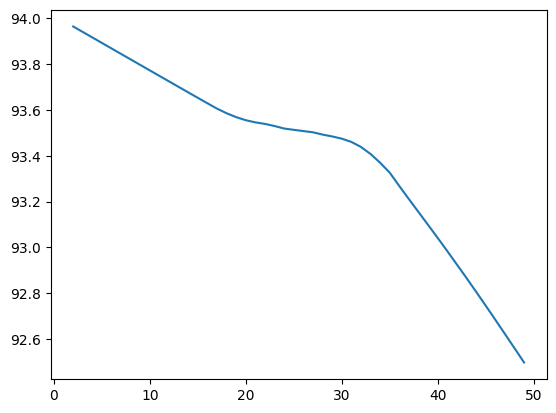

In [35]:
# visualize the lowess fit
lowess_fit
import matplotlib.pyplot as plt
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1])
plt.show()

In [36]:
pitstop

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10940,1089,854,1,33,15:52:21,24.817,24817,Mick,Schumacher,24817.0,2022,Italian Grand Prix,53,1,4836060,12,17,12,1:25.298,91246.415094
10941,1089,852,1,19,15:31:51,24.009,24009,Yuki,Tsunoda,23956.5,2022,Italian Grand Prix,52,11,\N,14,20,14,1:26.857,92862.903846
10942,1089,852,2,47,16:13:25,23.904,23904,Yuki,Tsunoda,23956.5,2022,Italian Grand Prix,52,11,\N,14,20,14,1:26.857,92862.903846
10943,1089,855,1,18,15:30:16,25.366,25366,Guanyu,Zhou,25366.0,2022,Italian Grand Prix,53,1,4835421,10,9,10,1:26.361,91234.358491


In [37]:
pitstop.loc[(pitstop['driverId'] == 1) & (pitstop['raceId'] == 1041)]

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
10537,1041,1,1,16,14:37:59,23.983,23983,Lewis,Hamilton,23581.5,2020,Eifel Grand Prix,60,1,5749641,1,2,1,1:28.145,95827.35
10538,1041,1,2,45,15:22:31,23.180,23180,Lewis,Hamilton,23581.5,2020,Eifel Grand Prix,60,1,5749641,1,2,1,1:28.145,95827.35


## Now calculate race finishing place:

I would need to know how much time is lost per pitstops
1. Calculate total number of pitstops and times
2. Subtract that total pitstop time from the final race time
3. reorder placing based on times

In [38]:
pitstop[(pitstop['raceId'] == 1041) & (pitstop['driverId'] == 1)].head()

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
10537,1041,1,1,16,14:37:59,23.983,23983,Lewis,Hamilton,23581.5,2020,Eifel Grand Prix,60,1,5749641,1,2,1,1:28.145,95827.35
10538,1041,1,2,45,15:22:31,23.180,23180,Lewis,Hamilton,23581.5,2020,Eifel Grand Prix,60,1,5749641,1,2,1,1:28.145,95827.35


In [39]:
pitstop['milliseconds'].dtype

dtype('int64')

In [40]:
pitstop.head()

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,year,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,2011,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,2011,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684


In [41]:
# Step 1: Calculate total pitstop time:
total_pitstops = pitstop.groupby(['raceId', 'driverId']).agg({'milliseconds': 'sum'}).reset_index(drop=False).rename(columns={'milliseconds': "totalPitStopTimeMs"})

# merge into the pitstops dataset
print(pitstop.shape)
pitstop = pitstop.merge(total_pitstops)
print(pitstop.shape)
pitstop.head()

(10945, 20)
(10945, 21)


,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,...,name,laps,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs,totalPitStopTimeMs
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,...,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158,77709
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,...,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158,77709
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,...,Australian Grand Prix,57,11,\N,11,12,11,1:30.467,95244.263158,77709
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,...,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684,49009
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,...,Australian Grand Prix,19,4,\N,19,11,\N,1:35.319,101762.473684,49009


In [42]:
# Replace "\N" with NaN to better represent the null values
pitstop = pitstop.replace("\\N", np.nan)

# Subtract pit stops times from total race time (only for status 1, any other status that is not 1 means the driver did not complete the race, meaning they are out of evaluation)
pitstop['timeWithoutPitStops'] =  pitstop['totalRaceTimeMilliseconds'].fillna(0).astype(int) - pitstop['totalPitStopTimeMs']

# Remove negatives from the new column
pitstop['timeWithoutPitStopsMs'] = pitstop['timeWithoutPitStops'].apply(lambda x: 0 if x < 0 else x)

# Convert the ms to minutes as the final new column to see the final race time
pitstop['timeWithoutPitStops'] = pitstop['timeWithoutPitStopsMs'].apply(convert_ms_to_sec)

In [43]:
pitstop.head()

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,...,statusId,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs,totalPitStopTimeMs,timeWithoutPitStops,timeWithoutPitStopsMs
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,...,11,NaN,11,12,11,1:30.467,95244.263158,77709,0:0.0,0
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,...,11,NaN,11,12,11,1:30.467,95244.263158,77709,0:0.0,0
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,...,11,NaN,11,12,11,1:30.467,95244.263158,77709,0:0.0,0
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,...,4,NaN,19,11,NaN,1:35.319,101762.473684,49009,0:0.0,0
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,...,4,NaN,19,11,NaN,1:35.319,101762.473684,49009,0:0.0,0


In [44]:
# Rerank driver positions for position order column based on the new and updated driver and only show unique drivers

pitstop['rank'] = pitstop.groupby(['raceId'])['timeWithoutPitStopsMs'].rank(ascending=True)

In [45]:
pitstop[pitstop['raceId'] == 1122]

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,...,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs,totalPitStopTimeMs,timeWithoutPitStops,timeWithoutPitStopsMs,rank
8966,1122,4,1,7,20:15:37,22.129,22129,Fernando,Alonso,22129.0,...,4879032,5,4,5,1:32.387,97580.640000,22129,80:56.903,4856903,12.0
8967,1122,1,1,36,21:03:38,20.170,20170,Lewis,Hamilton,20170.0,...,4890664,9,8,9,1:31.746,97813.280000,20170,81:10.494,4870494,16.0
8968,1122,815,1,7,20:15:30,22.196,22196,Sergio,Pérez,22196.0,...,4862704,2,3,2,1:32.273,97038.320000,22196,80:40.508,4840508,10.0
8969,1122,817,1,7,20:15:57,1:03.364,63364,Daniel,Ricciardo,63364.0,...,NaN,16,14,16,1:33.323,99265.061224,63364,0:0.0,0,4.0
8970,1122,807,1,33,20:59:21,21.035,21035,Nico,Hülkenberg,21035.0,...,4920269,10,15,10,1:32.366,98405.380000,21035,81:39.234,4899234,17.0
8971,1122,822,1,7,20:16:00,22.795,22795,Valtteri,Bottas,23038.0,...,NaN,17,16,17,1:32.706,99314.040816,46076,0:0.0,0,4.0
8972,1122,822,2,35,21:02:58,23.281,23281,Valtteri,Bottas,23038.0,...,NaN,17,16,17,1:32.706,99314.040816,46076,0:0.0,0,4.0
8973,1122,825,1,7,20:15:53,21.460,21460,Kevin,Magnussen,21460.0,...,4955646,12,13,12,1:32.338,98580.200000,21460,82:14.186,4934186,19.0
8974,1122,830,1,7,20:15:25,20.607,20607,Max,Verstappen,20607.0,...,4843273,1,1,1,1:31.773,96865.460000,20607,80:22.666,4822666,8.0
8975,1122,839,1,7,20:15:59,22.502,22502,Esteban,Ocon,22502.0,...,NaN,13,17,13,1:33.481,98923.959184,22502,0:0.0,0,4.0


In [46]:
# Get a race in 2024
results[results['raceId'] == 1122]

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,totalRaceTimeMilliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
26300,26306,1122,830,9,1,1,1,1,1,25.0,50,1:20:43.273,4843273,50,3,1:31.773,242.188,1
26301,26307,1122,815,9,11,3,2,2,2,18.0,50,+13.6431,4862704,37,8,1:32.273,240.876,1
26302,26308,1122,844,6,16,2,3,3,3,16.0,50,+18.639,4861912,50,1,1:31.632,242.561,1
26303,26309,1122,857,1,81,5,4,4,4,12.0,50,+32.007,4875280,1,10,1:32.310,240.779,1
26304,26310,1122,4,117,14,4,5,5,5,10.0,50,+35.759,4879032,43,13,1:32.387,240.579,1
26305,26311,1122,847,131,63,7,6,6,6,8.0,50,+39.936,4883209,42,7,1:32.254,240.926,1
26306,26312,1122,860,6,38,11,7,7,7,6.0,50,+42.679,4885952,50,5,1:32.186,241.103,1
26307,26313,1122,846,1,4,6,8,8,8,4.0,50,+45.708,4888981,1,4,1:31.944,241.738,1
26308,26314,1122,1,131,44,8,9,9,9,2.0,50,+47.391,4890664,38,2,1:31.746,242.260,1
26309,26315,1122,807,210,27,15,10,10,10,1.0,50,+1:16.996,4920269,49,12,1:32.366,240.633,1


In [47]:
drivers[drivers['driverId'] == 822]

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
821,822,bottas,77,BOT,Valtteri,Bottas,1989-08-28,Finnish,http://en.wikipedia.org/wiki/Valtteri_Bottas


In [48]:
zhou = fuel_correction(laptimes, results,  855, 1122)

/tmp/ipykernel_8526/102389479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptimes['fuel_remaining'] = 110 - ((laptimes['raceLapNumber'] / laptimes['raceLapNumber'].max()) * 110)
/tmp/ipykernel_8526/102389479.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptimes['adjustedLaptimeMilliseconds'] = laptimes['lapTimeMilliseconds'] - (laptimes['fuel_remaining'] * 30)


In [49]:
x = zhou['raceLapNumber']
y = zhou['adjustedLaptimeSec']
zhou_y = y
zhou_fit = lowess(y, x)

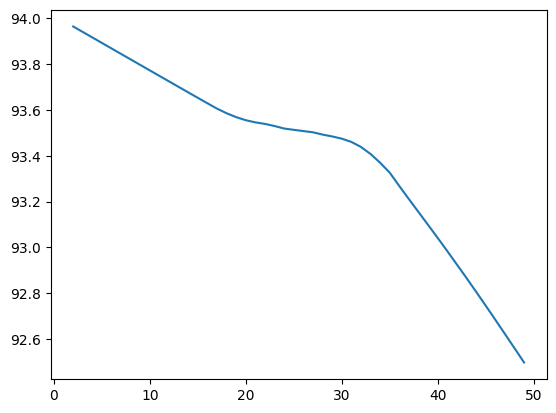

In [50]:
plt.plot(zhou_fit[:, 0], zhou_fit[:, 1])
plt.show()

In [51]:
bottas = fuel_correction(laptimes, results,  822, 1122)

/tmp/ipykernel_8526/102389479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptimes['fuel_remaining'] = 110 - ((laptimes['raceLapNumber'] / laptimes['raceLapNumber'].max()) * 110)
/tmp/ipykernel_8526/102389479.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptimes['adjustedLaptimeMilliseconds'] = laptimes['lapTimeMilliseconds'] - (laptimes['fuel_remaining'] * 30)


In [52]:
x = bottas['raceLapNumber']
y = bottas['adjustedLaptimeSec']
bottas_y = y
bottas_fit = lowess(y, x)

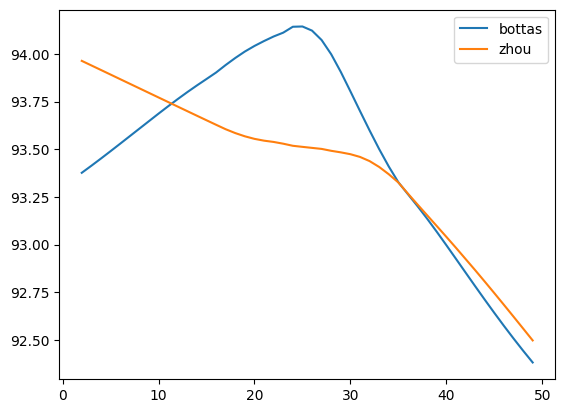

In [53]:
plt.plot(bottas_fit[:, 0], bottas_fit[:, 1], label = 'bottas')
plt.plot(zhou_fit[:, 0], zhou_fit[:, 1], label = 'zhou')
plt.legend()
plt.show()

In [54]:
zhou_y.mean()

93.49226716141001

In [55]:
bottas_y.mean()

93.81208719851578

# Find laptimes where drivers went in pit

1. I could grab from the pitstop table, taking the lap before (in lap) and lap after (out lap) as well
2. I could filter out lap anomolies as pitstops 

# TODO: 
I would need to get the laps when a driver has pitted and filter out the in lap and out lap, decide on a method to replace the lap times with and then use that as a measure to see where a driver would place without a pitstop. 

In [56]:
pitstop

,raceId,driverId,stop,lap,time,duration,milliseconds,forename,surname,avgPitStopTimeMs,...,totalRaceTimeMilliseconds,positionOrder,grid,position,fastestLapTime,avgLapTimeMs,totalPitStopTimeMs,timeWithoutPitStops,timeWithoutPitStopsMs,rank
0,841,153,1,1,17:05:23,26.898,26898,Jaime,Alguersuari,25903.0,...,NaN,11,12,11,1:30.467,95244.263158,77709,0:0.0,0,14.0
1,841,153,2,17,17:31:06,24.463,24463,Jaime,Alguersuari,25903.0,...,NaN,11,12,11,1:30.467,95244.263158,77709,0:0.0,0,14.0
2,841,153,3,35,17:59:45,26.348,26348,Jaime,Alguersuari,25903.0,...,NaN,11,12,11,1:30.467,95244.263158,77709,0:0.0,0,14.0
3,841,30,1,1,17:05:52,25.021,25021,Michael,Schumacher,24504.5,...,NaN,19,11,NaN,1:35.319,101762.473684,49009,0:0.0,0,14.0
4,841,30,2,17,17:32:08,23.988,23988,Michael,Schumacher,24504.5,...,NaN,19,11,NaN,1:35.319,101762.473684,49009,0:0.0,0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10940,1089,854,1,33,15:52:21,24.817,24817,Mick,Schumacher,24817.0,...,4836060,12,17,12,1:25.298,91246.415094,24817,80:11.243,4811243,27.0
10941,1089,852,1,19,15:31:51,24.009,24009,Yuki,Tsunoda,23956.5,...,NaN,14,20,14,1:26.857,92862.903846,47913,0:0.0,0,5.0
10942,1089,852,2,47,16:13:25,23.904,23904,Yuki,Tsunoda,23956.5,...,NaN,14,20,14,1:26.857,92862.903846,47913,0:0.0,0,5.0
10943,1089,855,1,18,15:30:16,25.366,25366,Guanyu,Zhou,25366.0,...,4835421,10,9,10,1:26.361,91234.358491,25366,80:10.55,4810055,26.0


## TODO: I need to start thinking each goal as an experiment. Structure each of the notebooks like that and focus on that main objective